In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0
/home/conda/envs/scrna/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/conda/envs/scrna/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
results_folder = './results/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Load datasets

In [3]:
# Read data
adata_vis = sc.read("data/visium_merge_inter_upload.h5ad")

In [4]:
adata_vis

AnnData object with n_obs × n_vars = 27912 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'donor_id', 'region'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-6800STDY12499406', 'mean_counts-6800STDY12499406', 'log1p_mean_counts-6800STDY12499406', 'pct_dropout_by_counts-6800STDY12499406', 'total_counts-6800STDY12499406', 'log1p_total_counts-6800STDY12499406', 'n_cells_by_counts-6800STDY12499407', 'mean_counts-6800STDY12499407', 'log1p_mean_counts-6800STDY12499407', 'pct_dropout_by_counts-6800STDY12499407', 'total_counts-6800STDY12499407', 'log1p_total_counts-6800STDY12499407', 'n_cells_by_counts-6800STDY12499408', 'mean_counts-6800STDY12499408', 'log1p_mean_counts-6800STDY12499408', 'pct_dropout_by_counts-6800STDY12499408', 'tot

`important` 注意adata_vis的数据结构：
1. 切片图像保存于`adata_vis.uns['spatial']`
2. 在cell2location中，切片转录组默认使用`adata_vis.obs['sample']`用于区分不同切片的数据

修改`adata_vis.uns['spatial']`的key值使之和`adata_vis.obs['sample']`保持一致，这样才能使用`select_slide`函数subset切片

In [5]:
for k in list(adata_vis.uns['spatial'].keys()):
    adata_vis.uns['spatial'][k.split('_')[3]] = adata_vis.uns['spatial'].pop(k) 

In [6]:
list(adata_vis.uns['spatial'].keys())

['6800STDY12499406',
 '6800STDY12499407',
 '6800STDY12499410',
 '6800STDY12499411',
 '6800STDY12499408',
 '6800STDY12499409',
 '6800STDY12499412',
 '6800STDY12499413',
 '6800STDY12499502',
 '6800STDY12499503',
 '6800STDY12499504',
 '6800STDY12499505',
 '6800STDY12499506',
 '6800STDY12499507',
 '6800STDY12499508',
 '6800STDY12499509']

In [7]:
adata_vis.obs[['sample', 'donor_id']].value_counts()

sample            donor_id
6800STDY12499406  PD43824     3352
6800STDY12499508  PD47465     2831
6800STDY12499509  PD47465     2811
6800STDY12499502  PD45814     2700
6800STDY12499504  PD45815     2670
6800STDY12499503  PD45814     2661
6800STDY12499505  PD45815     2580
6800STDY12499507  PD45816     2145
6800STDY12499409  PD47512     2085
6800STDY12499411  PD47171     2048
6800STDY12499506  PD45816     2029
dtype: int64

导入上一步的结果：reference signature

In [8]:
inf_aver = pd.read_csv(f"{ref_run_name}/inf_aver.csv", index_col=0)
inf_aver.head()

,ACKR+_EC,Activated KRT+ NK,Activated NK,Activated_B-AREG,Activated_B-RHOB,CCL5+_EC,CD,CD4+T_Act-CCL5,CD4+T_Act-CH25H,CD4+T_Act-CXCR4,...,TR Mac.3,Type A intercalated cell,Type B intercalated cell,cDC1,cDC2,cir_NK-PTGDS,cir_NK-S100B,gdT_Vd1,gdT_Vd2,pDC
FO538757.2,0.095478,0.090512,0.110985,0.055967,0.075919,0.074606,0.149572,0.084705,0.095956,0.096498,...,0.128304,0.104031,0.250288,0.090729,0.136187,0.130000,0.084518,0.122680,0.083116,0.134055
NOC2L,0.138662,0.127062,0.117580,0.117451,0.114746,0.082101,0.170084,0.105224,0.101670,0.108131,...,0.028709,0.076386,0.117015,0.069693,0.090842,0.123789,0.110760,0.140441,0.105666,0.130683
PERM1,0.002008,0.000344,0.000227,0.001351,0.002163,0.003590,0.025246,0.001045,0.008251,0.000158,...,0.003109,0.005901,0.482280,0.000646,0.001460,0.000493,0.003901,0.001227,0.000922,0.001944
HES4,0.011849,0.006743,0.051286,0.004431,0.004672,0.239193,0.127295,0.005886,0.009522,0.002642,...,0.009600,0.007545,0.044294,0.013336,0.001851,0.074820,0.109686,0.005783,0.001141,0.012366
ISG15,0.412864,0.386006,0.502053,0.174437,0.136781,0.391983,0.042844,0.363116,0.340214,0.340523,...,0.354593,0.026318,0.085551,0.235624,0.197040,0.441866,0.612398,0.588833,0.357066,0.088883


对参考数据和空转数据中基因取交集

In [9]:
adata_vis.var.head()

,feature_types,genome,SYMBOL,mt,n_cells_by_counts-6800STDY12499406,mean_counts-6800STDY12499406,log1p_mean_counts-6800STDY12499406,pct_dropout_by_counts-6800STDY12499406,total_counts-6800STDY12499406,log1p_total_counts-6800STDY12499406,...,log1p_mean_counts-6800STDY12499508,pct_dropout_by_counts-6800STDY12499508,total_counts-6800STDY12499508,log1p_total_counts-6800STDY12499508,n_cells_by_counts-6800STDY12499509,mean_counts-6800STDY12499509,log1p_mean_counts-6800STDY12499509,pct_dropout_by_counts-6800STDY12499509,total_counts-6800STDY12499509,log1p_total_counts-6800STDY12499509
ENSEMBL,,,,,,,,,,,,,,,,,,,,,
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000353,99.964677,1.0,0.693147,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000237613,Gene Expression,GRCh38,FAM138A,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000186092,Gene Expression,GRCh38,OR4F5,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ENSG00000238009,Gene Expression,GRCh38,AL627309.1,False,4,0.001193,0.001193,99.880668,4.0,1.609438,...,0.002822,99.717414,8.0,2.197225,1,0.000356,0.000356,99.964425,1.0,0.693147
ENSG00000239945,Gene Expression,GRCh38,AL627309.3,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000


In [10]:
is_dup = adata_vis.var["SYMBOL"].duplicated().tolist()
symbol = adata_vis.var["SYMBOL"].tolist()
ensembl = adata_vis.var.index.tolist()
uni_symbol = [(symbol[i]+"_"+ensembl[i]) if is_dup[i] else symbol[i] for i in range(len(is_dup))]

In [11]:
adata_vis.var_names = uni_symbol

In [12]:
adata_vis.var.head()

,feature_types,genome,SYMBOL,mt,n_cells_by_counts-6800STDY12499406,mean_counts-6800STDY12499406,log1p_mean_counts-6800STDY12499406,pct_dropout_by_counts-6800STDY12499406,total_counts-6800STDY12499406,log1p_total_counts-6800STDY12499406,...,log1p_mean_counts-6800STDY12499508,pct_dropout_by_counts-6800STDY12499508,total_counts-6800STDY12499508,log1p_total_counts-6800STDY12499508,n_cells_by_counts-6800STDY12499509,mean_counts-6800STDY12499509,log1p_mean_counts-6800STDY12499509,pct_dropout_by_counts-6800STDY12499509,total_counts-6800STDY12499509,log1p_total_counts-6800STDY12499509
MIR1302-2HG,Gene Expression,GRCh38,MIR1302-2HG,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000353,99.964677,1.0,0.693147,0,0.000000,0.000000,100.000000,0.0,0.000000
FAM138A,Gene Expression,GRCh38,FAM138A,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
OR4F5,Gene Expression,GRCh38,OR4F5,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
AL627309.1,Gene Expression,GRCh38,AL627309.1,False,4,0.001193,0.001193,99.880668,4.0,1.609438,...,0.002822,99.717414,8.0,2.197225,1,0.000356,0.000356,99.964425,1.0,0.693147
AL627309.3,Gene Expression,GRCh38,AL627309.3,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000


In [13]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [14]:
adata_vis.shape, inf_aver.shape

((27912, 10533), (10533, 103))

The reference signature model was further used by cell2location to estimate spatial abundance of cell
types. We kept genes that were shared with scRNA-seq and estimated the abundance of cell types in tumor core and interface
groups respectively. In this step, cell2location was used with the following parameter settings: 
- training iterations: 20,000, 
- number of cells per location N = 20, 
- ‘detection_alpha’ = 200

In [15]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [16]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=20,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=200
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.17.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│          n_vars          │ 10533 │
│         n_cells          │ 27912 │
│         n_batch          │  11   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                      batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ 6800STDY12499406 │          0          │
│                     │ 6800STDY12499409 │          1          │
│                     │ 6800STDY12499411 │          2          │
│                     │ 6800STDY12499502 │          3          │
│                     │ 6800STDY12499503 │          4          │
│                     │ 6800STDY12499504 │          5          │
│                     │ 6800STDY12499505 │          6          │
│                     │ 6800STDY12499506 │          7          │
│                     │ 6800STDY12499507 │          8          │
│                     │ 6800STDY12499508 │          9          │
│                     │ 6800STDY12499509 │         10          │
└─────────────────────┴──────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

这里我们使用一个较小的迭代次数，减小模型训练时间

In [ ]:
## 使用GPU训练
# import torch
# if torch.cuda.is_available():
#     mod.train(max_epochs=10000, batch_size=None, train_size=1, use_gpu=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/conda/envs/scrna/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/home/conda/envs/scrna/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 2902/10000:  29%|██     | 2901/10000 [2:38:32<6:03:49,  3.08s/it, v_num=1, elbo_train=1.04e+8]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 6788/10000:  68%|████▊  | 6787/10000 [6:09:33<2:59:12,  3.35s/it, v_num=1, elbo_train=1.04e+8]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 10000/10000: 100%|███████| 10000/10000 [9:00:52<00:00,  3.03s/it, v_num=1, elbo_train=1.03e+8]

`Trainer.fit` stopped: `max_epochs=10000` reached.


Epoch 10000/10000: 100%|███████| 10000/10000 [9:00:52<00:00,  3.25s/it, v_num=1, elbo_train=1.03e+8]


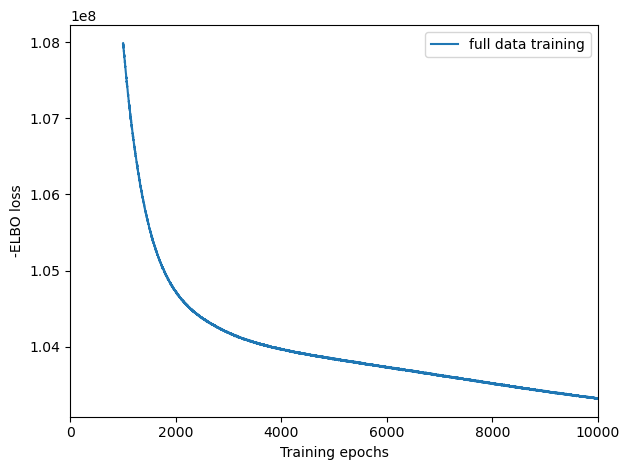

In [17]:
mod.train(max_epochs=10000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

cell2location最终的结果是输出一个后验概率，用来表示spot中不同细胞类型的丰度。
最终的结果存储在`adata_vis.obsm`中。
- 注意： cell2location给出的每种细胞在每个spot中的后验概率其实是一个分布。export_posterior函数输出的是这个分布的均值，5%分位数，95%分位数来代表这个分布。

In [18]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████████████████████| 999/999 [06:21<00:00,  2.62it/s]


'./results//cell2location_map/sp.h5ad'

散点图具有正相关的趋势说明模型可以用来解释数据

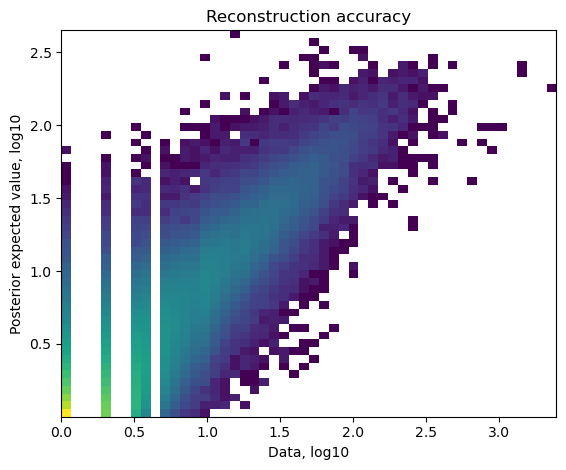

In [19]:
mod.plot_QC()